# **AGCN- Install Dependencies**

In [ ]:
# Cell 1: Install Dependencies (A100 optimized)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install tensorboardX tqdm pyyaml einops
!pip install torchinfo

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 125.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 16.7 MB/s e

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Setup and Imports**

In [ ]:
# Cell 2: Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
from torchinfo import summary
from torch.cuda import amp

# Enable TF32 for A100 GPU (3x faster)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


Using device: cuda


In [ ]:
import numpy as np
import pickle
import os

# Data/label locations (edit for X-View or bone if needed)
train_data = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
val_data   = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
val_label   = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# Check files exist
print("Train data:", os.path.exists(train_data), "| Val data:", os.path.exists(val_data))
print("Train label:", os.path.exists(train_label), "| Val label:", os.path.exists(val_label))

# Print label counts and a sample
with open(train_label, 'rb') as f:
    sample_names, sample_labels = pickle.load(f)
print(f"Train samples: {len(sample_labels)} | Example label: {sample_labels[0]}")
with open(val_label, 'rb') as f:
    val_names, val_labels = pickle.load(f)
print(f"Val samples: {len(val_labels)} | Example label: {val_labels[0]}")

# Print one data sample shape
sample = np.load(train_data, mmap_mode='r')
print("Train data shape (N,C,T,V,M):", sample.shape)
print("One sample min/max:", sample[0].min(), sample[0].max())


Train data: True | Val data: True
Train label: True | Val label: True
Train samples: 33383 | Example label: 16
Val samples: 23327 | Example label: 13
Train data shape (N,C,T,V,M): (33383, 3, 300, 25, 2)
One sample min/max: -1.9420302618199796 0.8381361333212642


In [ ]:
print("Unique classes in train:", len(set(sample_labels)))
print("Unique classes in val:", len(set(val_labels)))


Unique classes in train: 60
Unique classes in val: 60


In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # For reproducibility, disable CUDNN benchmark and enable deterministic
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(42)


# **Enhanced Feeder Class**

In [ ]:
# Cell 3: Enhanced Feeder Class with Augmentation
class Feeder(Dataset):
    def __init__(self, data_path, label_path, train=False, debug=False, use_mmap=True):
        self.debug = debug
        self.data_path = data_path
        self.label_path = label_path
        self.use_mmap = use_mmap
        self.train = train
        self.load_data()

    def load_data(self):
        with open(self.label_path, 'rb') as f:
            try:
                self.sample_name, self.label = pickle.load(f)
            except:
                self.sample_name, self.label = pickle.load(f, encoding='latin1')
        if self.use_mmap:
            self.data = np.load(self.data_path, mmap_mode='r')
        else:
            self.data = np.load(self.data_path)
        if self.debug:
            self.label = self.label[:100]
            self.data = self.data[:100]
            self.sample_name = self.sample_name[:100]

    def temporal_crop(self, data, crop_length=300):
        """Random temporal cropping with 10% variation"""
        T = data.shape[1]
        if T > crop_length:
            start = np.random.randint(0, T - crop_length)
            return data[:, start:start+crop_length, :, :]
        return data

    def spatial_flip(self, data):
        """Random spatial flip with 50% probability"""
        if np.random.rand() > 0.5:
            data[0] = -data[0]  # Flip x-axis coordinates
        return data

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        data = np.array(self.data[idx])  # Convert mmap to array

        if self.train:
            data = self.temporal_crop(data)
            data = self.spatial_flip(data)

        return data, int(self.label[idx])


# **Official Code AGCN**

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np

def conv_branch_init(conv, branches):
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    nn.init.normal_(weight, 0, math.sqrt(2. / (n * k1 * k2 * branches)))
    nn.init.constant_(conv.bias, 0)

def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    nn.init.constant_(conv.bias, 0)

def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

class unit_tcn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(unit_tcn, self).__init__()
        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                              stride=(stride, 1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        conv_init(self.conv)
        bn_init(self.bn, 1)
    def forward(self, x):
        x = self.bn(self.conv(x))
        return x

class unit_gcn(nn.Module):
    def __init__(self, in_channels, out_channels, A, coff_embedding=4, num_subset=3):
        super(unit_gcn, self).__init__()
        inter_channels = out_channels // coff_embedding
        self.inter_c = inter_channels
        self.PA = nn.Parameter(torch.from_numpy(A.astype(np.float32)))
        nn.init.constant_(self.PA, 1e-6)
        self.A = torch.tensor(A.astype(np.float32), requires_grad=False)
        self.num_subset = num_subset
        self.conv_a = nn.ModuleList()
        self.conv_b = nn.ModuleList()
        self.conv_d = nn.ModuleList()
        for i in range(self.num_subset):
            self.conv_a.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_b.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_d.append(nn.Conv2d(in_channels, out_channels, 1))
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = lambda x: x
        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.relu = nn.ReLU(inplace=True)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)
        bn_init(self.bn, 1e-6)
        for i in range(self.num_subset):
            conv_branch_init(self.conv_d[i], self.num_subset)
    def forward(self, x):
        N, C, T, V = x.size()
        A = self.A.to(x.device) + self.PA
        y = None
        for i in range(self.num_subset):
            A1 = self.conv_a[i](x).permute(0, 3, 1, 2).contiguous().view(N, V, self.inter_c * T)
            A2 = self.conv_b[i](x).view(N, self.inter_c * T, V)
            # Stable softmax to prevent NaN
            temp = torch.matmul(A1, A2) / (A1.size(-1) + 1e-8)
            temp = torch.clamp(temp, -50, 50)
            A1 = self.soft(temp)
            A1 = A1 + A[i]
            A2 = x.view(N, C * T, V)
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))
            y = z + y if y is not None else z
        y = self.bn(y)
        y += self.down(x)
        return self.relu(y)

class TCN_GCN_unit(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True):
        super(TCN_GCN_unit, self).__init__()
        self.gcn1 = unit_gcn(in_channels, out_channels, A)
        self.tcn1 = unit_tcn(out_channels, out_channels, stride=stride)
        self.relu = nn.ReLU(inplace=True)
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)
    def forward(self, x):
        x = self.tcn1(self.gcn1(x)) + self.residual(x)
        return self.relu(x)

class Model(nn.Module):
    def __init__(self, num_class=60, num_point=25, num_person=2, graph=None, graph_args=dict(), in_channels=3):
        super(Model, self).__init__()
        class Graph:
            def __init__(self, labeling_mode='spatial'):
                self.num_node = 25
                self.self_link = [(i, i) for i in range(self.num_node)]
                inward_ori_index = [
                    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5), (7, 6),
                    (8, 7), (9, 21), (10, 9), (11, 10), (12, 11), (13, 1),
                    (14, 13), (15, 14), (16, 15), (17, 1), (18, 17), (19, 18),
                    (20, 19), (22, 23), (23, 8), (24, 25), (25, 12)
                ]
                inward = [(i - 1, j - 1) for (i, j) in inward_ori_index]
                outward = [(j, i) for (i, j) in inward]
                neighbor = inward + outward
                def edge2mat(link, num_node):
                    A = np.zeros((num_node, num_node))
                    for i, j in link:
                        A[j, i] = 1
                    return A
                def normalize_digraph(A):
                    Dl = np.sum(A, 0)
                    h, w = A.shape
                    Dn = np.zeros((w, w))
                    for i in range(w):
                        if Dl[i] > 0:
                            Dn[i, i] = Dl[i] ** (-1)
                    AD = np.dot(A, Dn)
                    return AD
                def get_spatial_graph(num_node, self_link, inward, outward):
                    I = edge2mat(self_link, num_node)
                    In = normalize_digraph(edge2mat(inward, num_node))
                    Out = normalize_digraph(edge2mat(outward, num_node))
                    A = np.stack((I, In, Out))
                    return A
                self.A = get_spatial_graph(self.num_node, self.self_link, inward, outward)
        GraphObj = Graph(**graph_args)
        A = GraphObj.A
        self.data_bn = nn.BatchNorm1d(num_person * in_channels * num_point)
        self.l1 = TCN_GCN_unit(3, 64, A, residual=False)
        self.l2 = TCN_GCN_unit(64, 64, A)
        self.l3 = TCN_GCN_unit(64, 64, A)
        self.l4 = TCN_GCN_unit(64, 64, A)
        self.l5 = TCN_GCN_unit(64, 128, A, stride=2)
        self.l6 = TCN_GCN_unit(128, 128, A)
        self.l7 = TCN_GCN_unit(128, 128, A)
        self.l8 = TCN_GCN_unit(128, 256, A, stride=2)
        self.l9 = TCN_GCN_unit(256, 256, A)
        self.l10 = TCN_GCN_unit(256, 256, A)
        self.fc = nn.Linear(256, num_class)
        nn.init.normal_(self.fc.weight, 0, math.sqrt(2. / num_class))
        bn_init(self.data_bn, 1)
    def forward(self, x):
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous().view(N, M * V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T).permute(0, 1, 3, 4, 2).contiguous().view(N * M, C, T, V)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = self.l8(x)
        x = self.l9(x)
        x = self.l10(x)
        c_new = x.size(1)
        x = x.view(N, M, c_new, -1)
        x = x.mean(3).mean(1)
        return self.fc(x)


# **Model Summary**

In [ ]:
from torchinfo import summary
import torch

BATCH_SIZE = 72  # You can set this to 64, 72, or whatever your training uses
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dummy input for NTU RGB+D skeleton: (batch, C, T, V, M)
dummy_input_size = (BATCH_SIZE, 3, 300, 25, 2)

# Import your Model class as AGCN if needed (alias)
# from your_model_file import Model as AGCN

model = Model(num_class=60, num_point=25, num_person=2).to(DEVICE)

# It's good practice to always move model to correct device *before* summary
summary(model, input_size=dummy_input_size, device=DEVICE.type)


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [72, 60]                  --
├─BatchNorm1d: 1-1                       [72, 150, 300]            300
├─TCN_GCN_unit: 1-2                      [144, 64, 300, 25]        --
│    └─unit_gcn: 2-1                     [144, 64, 300, 25]        1,875
│    │    └─ModuleList: 3-9              --                        (recursive)
│    │    └─ModuleList: 3-10             --                        (recursive)
│    │    └─Softmax: 3-3                 [144, 25, 25]             --
│    │    └─ModuleList: 3-12             --                        (recursive)
│    │    └─ModuleList: 3-9              --                        (recursive)
│    │    └─ModuleList: 3-10             --                        (recursive)
│    │    └─Softmax: 3-7                 [144, 25, 25]             --
│    │    └─ModuleList: 3-12             --                        (recursive)
│    │    └─ModuleList: 3-9

# **Training Loop**

In [ ]:
def train_and_evaluate_agcn(
    train_data_path, train_label_path,
    val_data_path, val_label_path,
    save_path, batch_size=72, epochs=80, patience=15, plot_prefix=None
):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create datasets with augmentation for training
    train_set = Feeder(train_data_path, train_label_path, train=True)
    val_set = Feeder(val_data_path, val_label_path)

    # Custom collate function
    def custom_collate(batch):
        data = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        data = torch.stack([torch.from_numpy(np.copy(d)).float() for d in data], 0)
        labels = torch.LongTensor(labels)
        return data, labels

    # Create dataloaders
    train_loader = DataLoader(train_set, batch_size=batch_size,
                             shuffle=True, num_workers=2,
                             pin_memory=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_set, batch_size=batch_size,
                           shuffle=False, num_workers=1,
                           collate_fn=custom_collate)

    # Initialize model
    model = Model(num_class=60, num_point=25, num_person=2).to(DEVICE)

    # Optimizer and scheduler
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
                         nesterov=True, weight_decay=0.0005)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[35, 45, 55], gamma=0.2)
    criterion = nn.CrossEntropyLoss()

    # Mixed precision scaler - UPDATED SYNTAX
    scaler = torch.cuda.amp.GradScaler()  # No arguments needed

    best_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss, total, correct = 0.0, 0, 0

        # Training loop with mixed precision - UPDATED SYNTAX
        for data, label in train_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            optimizer.zero_grad()

            # UPDATED AUTOCAST SYNTAX
            with torch.cuda.amp.autocast():
                outputs = model(data)
                loss = criterion(outputs, label)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_total, val_correct = 0.0, 0, 0
        with torch.no_grad():
            for data, label in val_loader:
                data, label = data.to(DEVICE), label.to(DEVICE)
                outputs = model(data)
                loss = criterion(outputs, label)
                val_loss += loss.item() * data.size(0)
                _, predicted = outputs.max(1)
                val_total += label.size(0)
                val_correct += predicted.eq(label).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total
        epoch_time = time.time() - start_time

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Update scheduler
        scheduler.step()

        print(f"Epoch {epoch+1:2d}/{epochs} | Time: {epoch_time:.1f}s | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch+1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"  New best model saved! (Acc: {best_acc:.4f})")

            # Early exit if target achieved
            if best_acc >= 0.912:  # 91.2% accuracy target
                print("  Target accuracy reached! Stopping early.")
                break
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print(f"Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")

    # Plotting
    if plot_prefix:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.legend()
        plt.title('Loss Curve')

        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.axhline(y=0.912, color='r', linestyle='--', label='Target')
        plt.legend()
        plt.title('Accuracy Curve')

        plt.tight_layout()
        plt.savefig(f"{plot_prefix}_training_curve.png")
        plt.show()

    return best_acc, best_epoch, history

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# **X-SUB AGCN**

Starting enhanced AGCN training with batch size 72...
Epoch  1/80 | Time: 272.6s | Train Loss: 3.2027 Acc: 0.1462 | Val Loss: 3.0325 Acc: 0.1629
  New best model saved! (Acc: 0.1629)
Epoch  2/80 | Time: 273.1s | Train Loss: 2.0695 Acc: 0.3768 | Val Loss: 2.2248 Acc: 0.3386
  New best model saved! (Acc: 0.3386)
Epoch  3/80 | Time: 272.4s | Train Loss: 1.5611 Acc: 0.5266 | Val Loss: 1.7356 Acc: 0.5030
  New best model saved! (Acc: 0.5030)
Epoch  4/80 | Time: 272.4s | Train Loss: 1.2713 Acc: 0.6141 | Val Loss: 1.3687 Acc: 0.5903
  New best model saved! (Acc: 0.5903)
Epoch  5/80 | Time: 272.6s | Train Loss: 1.1088 Acc: 0.6613 | Val Loss: 1.1740 Acc: 0.6518
  New best model saved! (Acc: 0.6518)
Epoch  6/80 | Time: 272.3s | Train Loss: 1.0033 Acc: 0.6946 | Val Loss: 1.2489 Acc: 0.6348
Epoch  7/80 | Time: 273.0s | Train Loss: 0.9349 Acc: 0.7181 | Val Loss: 1.1280 Acc: 0.6712
  New best model saved! (Acc: 0.6712)
Epoch  8/80 | Time: 272.9s | Train Loss: 0.8729 Acc: 0.7345 | Val Loss: 1.1140 Ac

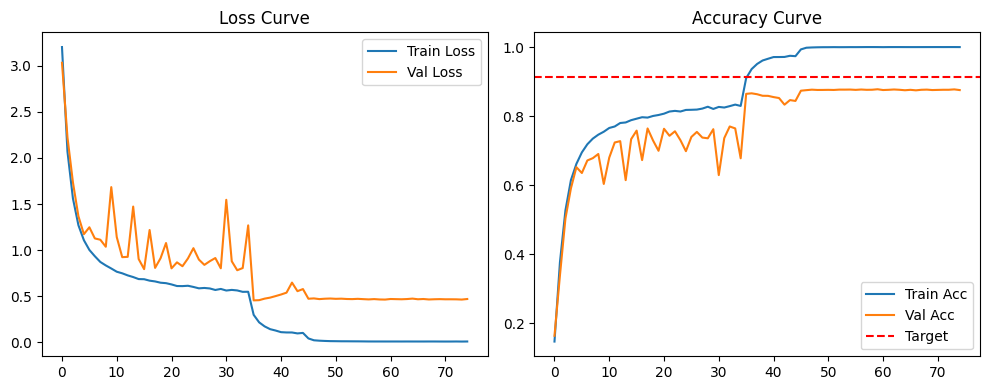


Final Best Validation Accuracy: 0.8777 at Epoch 60


In [ ]:
# Cell 6: Path Configuration (Update with your paths)
Xsub_train_data = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
Xsub_train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
Xsub_val_data = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
Xsub_val_label = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# Cell 7: Run Enhanced Training
print("Starting enhanced AGCN training with batch size 72...")
best_acc, best_epoch, history = train_and_evaluate_agcn(
    Xsub_train_data, Xsub_train_label,
    Xsub_val_data, Xsub_val_label,
    save_path='/content/improv_best_agcn_xsub_enhanced_72.pth',
    batch_size=72,
    epochs=80,
    patience=15,
    plot_prefix='AGCN_XSUB'
)

print(f"\nFinal Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")


# **X-VIEW Result AGCN**

Starting enhanced AGCN training with batch size 72...
Epoch  1/80 | Time: 287.5s | Train Loss: 3.0038 Acc: 0.1856 | Val Loss: 2.5975 Acc: 0.2470
  New best model saved! (Acc: 0.2470)
Epoch  2/80 | Time: 288.0s | Train Loss: 1.8488 Acc: 0.4454 | Val Loss: 2.1391 Acc: 0.4218
  New best model saved! (Acc: 0.4218)
Epoch  3/80 | Time: 287.4s | Train Loss: 1.3924 Acc: 0.5809 | Val Loss: 1.3738 Acc: 0.5882
  New best model saved! (Acc: 0.5882)
Epoch  4/80 | Time: 287.4s | Train Loss: 1.1709 Acc: 0.6496 | Val Loss: 1.3812 Acc: 0.5870
Epoch  5/80 | Time: 287.1s | Train Loss: 1.0326 Acc: 0.6884 | Val Loss: 1.5491 Acc: 0.5597
Epoch  6/80 | Time: 287.3s | Train Loss: 0.9469 Acc: 0.7146 | Val Loss: 1.0723 Acc: 0.6745
  New best model saved! (Acc: 0.6745)
Epoch  7/80 | Time: 287.3s | Train Loss: 0.8861 Acc: 0.7302 | Val Loss: 1.1684 Acc: 0.6572
Epoch  8/80 | Time: 287.4s | Train Loss: 0.8446 Acc: 0.7426 | Val Loss: 1.1592 Acc: 0.6551
Epoch  9/80 | Time: 287.2s | Train Loss: 0.8061 Acc: 0.7557 | Val 

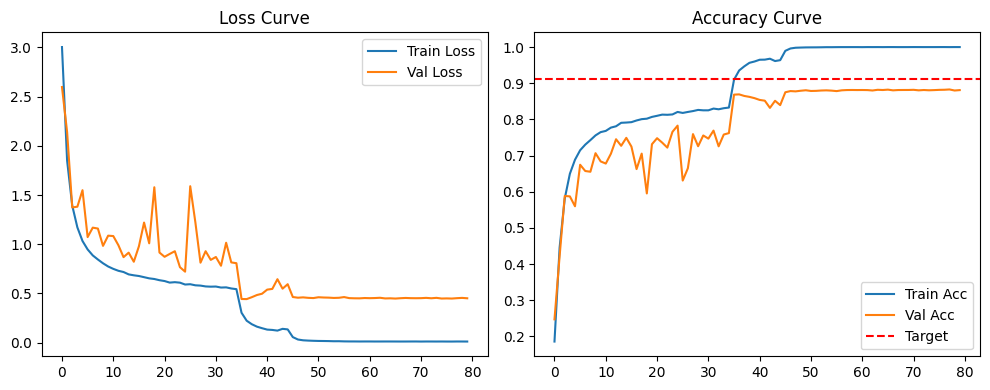


Final Best Validation Accuracy: 0.8827 at Epoch 78


In [ ]:
# Cell 6: Path Configuration (Update with your paths)
Xview_train_data = '/content/drive/MyDrive/ntu_normalized/xview_train_data_joint.npy'
Xview_train_label = '/content/drive/MyDrive/ntu_processed/xview/train/train_label.pkl'
Xview_val_data = '/content/drive/MyDrive/ntu_normalized/xview_val_data_joint.npy'
Xview_val_label = '/content/drive/MyDrive/ntu_processed/xview/val/val_label.pkl'

# Cell 7: Run Enhanced Training
print("Starting enhanced AGCN training with batch size 72...")
best_acc, best_epoch, history = train_and_evaluate_agcn(
    Xview_train_data, Xview_train_label,
    Xview_val_data, Xview_val_label,
    save_path='/content/improv_best_agcn_xview_72_enhanced.pth',
    batch_size=72,
    epochs=80,
    patience=60,
    plot_prefix='AGCN_XView'
)

print(f"\nFinal Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")


# **AGCN Heatmaps and matrix**

# **Comparison Shift-GCN**

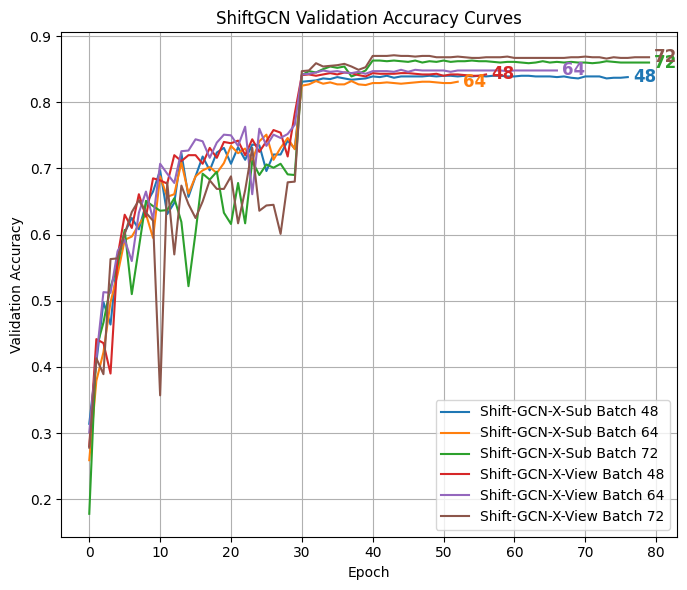

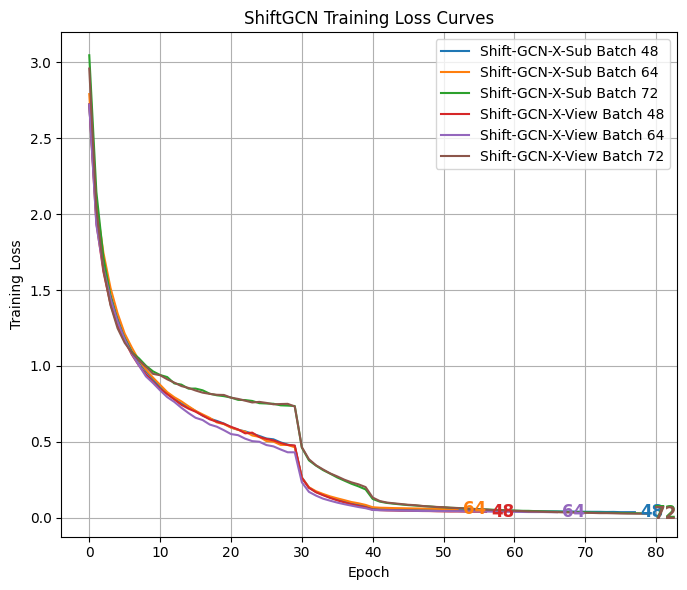

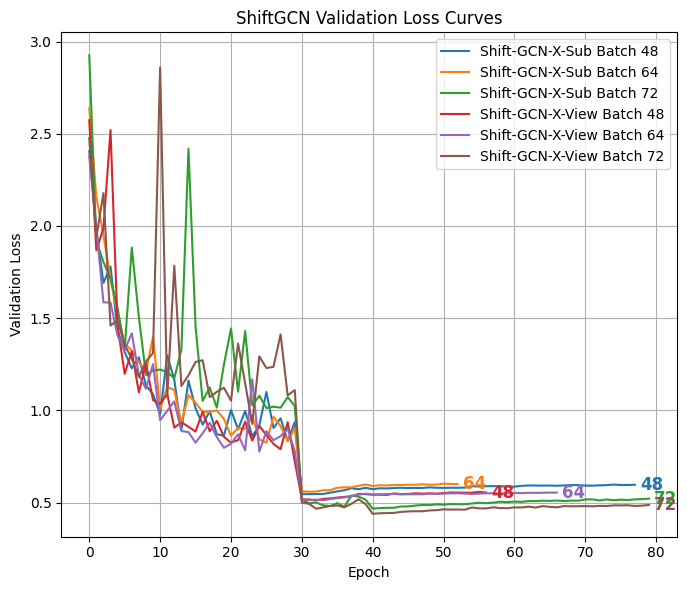

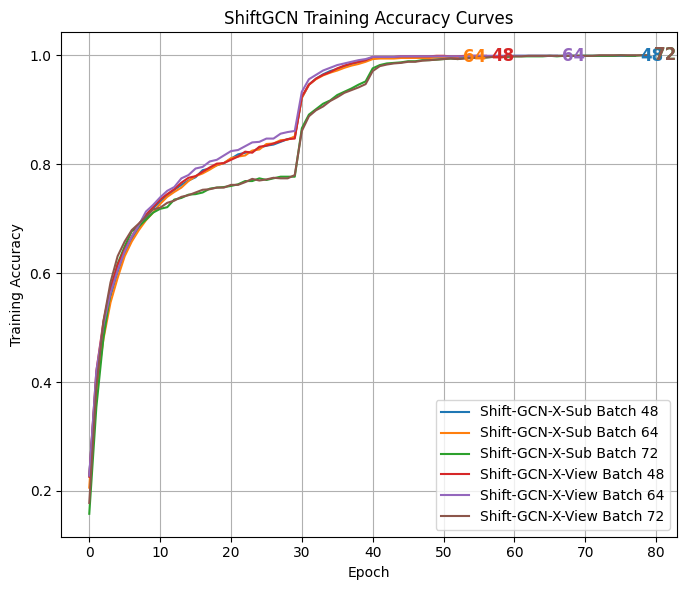

In [3]:
import matplotlib.pyplot as plt

def annotate_curve(y, label, x_shift=0.7, y_shift=0, color=None):
    plt.text(len(y)-1 + x_shift, y[-1] + y_shift, label, fontsize=12, color=color, va='center', fontweight='bold')


train_loss_72_xsub = [
    3.0454, 2.1460, 1.7131, 1.4587, 1.2942, 1.1801, 1.0893, 1.0506, 1.0013, 0.9642,
    0.9404, 0.9268, 0.8851, 0.8771, 0.8507, 0.8511, 0.8396, 0.8171, 0.8069, 0.8012,
    0.7920, 0.7769, 0.7754, 0.7695, 0.7550, 0.7528, 0.7510, 0.7409, 0.7390, 0.7362,
    0.4629, 0.3787, 0.3439, 0.3142, 0.2909, 0.2658, 0.2451, 0.2245, 0.2072, 0.1871,
    0.1244, 0.1069, 0.0982, 0.0930, 0.0882, 0.0839, 0.0810, 0.0776, 0.0753, 0.0711,
    0.0696, 0.0662, 0.0648, 0.0622, 0.0596, 0.0573, 0.0552, 0.0533, 0.0516, 0.0500,
    0.0482, 0.0464, 0.0461, 0.0441, 0.0429, 0.0414, 0.0410, 0.0392, 0.0387, 0.0374,
    0.0368, 0.0351, 0.0341, 0.0337, 0.0327, 0.0321, 0.0310, 0.0307, 0.0299, 0.0295
]
train_acc_72_xsub = [
    0.158, 0.354, 0.481, 0.564, 0.617, 0.649, 0.677, 0.686, 0.698, 0.711,
    0.718, 0.721, 0.735, 0.738, 0.744, 0.745, 0.748, 0.755, 0.757, 0.758,
    0.760, 0.763, 0.769, 0.769, 0.774, 0.771, 0.774, 0.777, 0.777, 0.777,
    0.866, 0.891, 0.901, 0.911, 0.917, 0.927, 0.933, 0.939, 0.946, 0.952,
    0.976, 0.982, 0.985, 0.986, 0.987, 0.989, 0.989, 0.991, 0.991, 0.992,
    0.993, 0.994, 0.993, 0.995, 0.995, 0.996, 0.996, 0.997, 0.997, 0.997,
    0.998, 0.998, 0.998, 0.998, 0.998, 0.999, 0.998, 0.999, 0.999, 0.999,
    0.999, 0.999, 0.999, 0.999, 0.999, 1.000, 0.999, 0.999, 1.000, 1.000
]
val_loss_72_xsub = [
    2.9256, 1.9181, 1.8045, 1.7153, 1.5539, 1.3334, 1.8835, 1.5066, 1.1924, 1.2155,
    1.2218, 1.2075, 1.1742, 1.3295, 2.4193, 1.4549, 1.0516, 1.1246, 1.0153, 1.2474,
    1.4442, 1.1017, 1.4306, 1.0275, 1.0795, 1.0129, 1.0204, 1.0150, 1.0717, 1.0254,
    0.5177, 0.4969, 0.5012, 0.4856, 0.4817, 0.4974, 0.4785, 0.5384, 0.5330, 0.5162,
    0.4674, 0.4709, 0.4721, 0.4723, 0.4793, 0.4796, 0.4841, 0.4874, 0.4868, 0.4909,
    0.4892, 0.4926, 0.4914, 0.4913, 0.4956, 0.4996, 0.4973, 0.5001, 0.5053, 0.5030,
    0.5059, 0.5045, 0.5085, 0.5087, 0.5109, 0.5097, 0.5115, 0.5090, 0.5114, 0.5107,
    0.5175, 0.5179, 0.5123, 0.5174, 0.5135, 0.5162, 0.5142, 0.5178, 0.5196, 0.5217
]
val_acc_72_xsub = [
    0.178, 0.428, 0.467, 0.521, 0.553, 0.607, 0.510, 0.580, 0.651, 0.643,
    0.636, 0.637, 0.655, 0.619, 0.522, 0.603, 0.692, 0.683, 0.695, 0.633,
    0.616, 0.678, 0.617, 0.711, 0.690, 0.706, 0.701, 0.707, 0.691, 0.690,
    0.841, 0.847, 0.845, 0.850, 0.854, 0.852, 0.854, 0.839, 0.843, 0.848,
    0.863, 0.863, 0.862, 0.863, 0.862, 0.861, 0.863, 0.860, 0.862, 0.861,
    0.863, 0.861, 0.862, 0.862, 0.863, 0.862, 0.862, 0.861, 0.860, 0.861,
    0.861, 0.860, 0.859, 0.860, 0.862, 0.860, 0.861, 0.860, 0.861, 0.860,
    0.860, 0.859, 0.860, 0.862, 0.861, 0.860, 0.860, 0.860, 0.860, 0.860
]
train_loss_72_xview = [
    2.9579, 2.0395, 1.6319, 1.3990, 1.2477, 1.1520, 1.0882, 1.0375, 0.9949, 0.9479,
    0.9390, 0.9121, 0.8903, 0.8676, 0.8553, 0.8384, 0.8242, 0.8162, 0.8102, 0.8090,
    0.7913, 0.7830, 0.7714, 0.7597, 0.7635, 0.7566, 0.7474, 0.7493, 0.7506, 0.7331,
    0.4653, 0.3860, 0.3461, 0.3185, 0.2926, 0.2728, 0.2513, 0.2338, 0.2206, 0.2025,
    0.1337, 0.1107, 0.1007, 0.0957, 0.0910, 0.0862, 0.0835, 0.0784, 0.0746, 0.0720,
    0.0700, 0.0666, 0.0642, 0.0618, 0.0592, 0.0555, 0.0550, 0.0509, 0.0500, 0.0486,
    0.0461, 0.0448, 0.0423, 0.0419, 0.0401, 0.0390, 0.0375, 0.0360, 0.0349, 0.0341,
    0.0330, 0.0324, 0.0310, 0.0310, 0.0300, 0.0286, 0.0282, 0.0276, 0.0274, 0.0267
]

train_acc_72_xview = [
    0.178, 0.389, 0.512, 0.583, 0.631, 0.658, 0.679, 0.691, 0.704, 0.717,
    0.720, 0.729, 0.733, 0.740, 0.743, 0.748, 0.753, 0.754, 0.757, 0.757,
    0.762, 0.762, 0.767, 0.773, 0.770, 0.772, 0.775, 0.774, 0.774, 0.780,
    0.861, 0.888, 0.899, 0.906, 0.916, 0.923, 0.931, 0.936, 0.941, 0.947,
    0.971, 0.980, 0.983, 0.985, 0.986, 0.988, 0.988, 0.990, 0.991, 0.992,
    0.993, 0.994, 0.993, 0.994, 0.995, 0.996, 0.996, 0.997, 0.997, 0.998,
    0.998, 0.998, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999,
    0.999, 0.999, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000
]

val_loss_72_xview = [
    2.4767, 1.9399, 2.1779, 1.4604, 1.4888, 1.3540, 1.2807, 1.1818, 1.2650, 1.3111,
    2.8590, 1.0722, 1.7852, 1.1325, 1.1905, 1.2631, 1.2722, 1.0723, 1.1006, 1.1233,
    1.0528, 1.3633, 1.1462, 0.9270, 1.2928, 1.2298, 1.2367, 1.4124, 1.0813, 1.1105,
    0.5000, 0.4941, 0.4676, 0.4739, 0.4822, 0.4846, 0.4747, 0.4938, 0.5182, 0.4921,
    0.4397, 0.4427, 0.4434, 0.4447, 0.4501, 0.4526, 0.4536, 0.4534, 0.4577, 0.4595,
    0.4639, 0.4626, 0.4631, 0.4619, 0.4740, 0.4691, 0.4688, 0.4747, 0.4707, 0.4702,
    0.4743, 0.4740, 0.4784, 0.4735, 0.4814, 0.4774, 0.4748, 0.4816, 0.4804, 0.4808,
    0.4817, 0.4802, 0.4826, 0.4820, 0.4851, 0.4853, 0.4860, 0.4823, 0.4837, 0.4880
]

val_acc_72_xview = [
    0.278, 0.413, 0.389, 0.563, 0.564, 0.601, 0.634, 0.652, 0.633, 0.621,
    0.357, 0.679, 0.570, 0.674, 0.646, 0.625, 0.650, 0.682, 0.669, 0.669,
    0.688, 0.617, 0.667, 0.731, 0.636, 0.644, 0.645, 0.601, 0.679, 0.680,
    0.847, 0.848, 0.859, 0.854, 0.855, 0.856, 0.858, 0.854, 0.849, 0.853,
    0.870, 0.870, 0.870, 0.871, 0.870, 0.870, 0.869, 0.870, 0.870, 0.868,
    0.868, 0.868, 0.869, 0.868, 0.867, 0.867, 0.868, 0.868, 0.868, 0.869,
    0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.868, 0.868,
    0.869, 0.868, 0.868, 0.866, 0.868, 0.867, 0.867, 0.868, 0.868, 0.868
]


# Fill these with your 48 batch size arrays from your logs (similar structure as above):
# X-Sub Batch 48
train_loss_48_xsub = [
    2.7205, 1.9879, 1.6863, 1.4665, 1.3162, 1.1964, 1.0989, 1.0283, 0.9653, 0.9124, 0.8612, 0.8207,
    0.7855, 0.7523, 0.7297, 0.7033, 0.6730, 0.6533, 0.6382, 0.6208, 0.5957, 0.5795, 0.5694, 0.5537,
    0.5392, 0.5224, 0.5169, 0.4969, 0.4822, 0.4724, 0.2665, 0.1998, 0.1704, 0.1518, 0.1336, 0.1215,
    0.1088, 0.0977, 0.0865, 0.0774, 0.0618, 0.0595, 0.0578, 0.0573, 0.0567, 0.0550, 0.0550, 0.0533,
    0.0519, 0.0528, 0.0509, 0.0509, 0.0503, 0.0490, 0.0491, 0.0486, 0.0473, 0.0469, 0.0462, 0.0466,
    0.0449, 0.0451, 0.0437, 0.0435, 0.0429, 0.0429, 0.0424, 0.0420, 0.0417, 0.0408, 0.0401, 0.0397,
    0.0396, 0.0386, 0.0391, 0.0374, 0.0375, 0.0375
]
train_acc_48_xsub = [
    0.228, 0.410, 0.492, 0.557, 0.602, 0.637, 0.663, 0.682, 0.701, 0.719, 0.731, 0.742,
    0.753, 0.762, 0.770, 0.776, 0.789, 0.792, 0.798, 0.802, 0.810, 0.818, 0.821, 0.823,
    0.830, 0.834, 0.836, 0.841, 0.846, 0.849, 0.922, 0.946, 0.957, 0.965, 0.971, 0.975,
    0.980, 0.984, 0.987, 0.990, 0.995, 0.995, 0.996, 0.996, 0.996, 0.996, 0.997, 0.997,
    0.997, 0.997, 0.998, 0.997, 0.997, 0.998, 0.998, 0.998, 0.998, 0.998, 0.998, 0.998,
    0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999,
    0.999, 0.999, 0.999, 0.999, 0.999, 0.999
]
val_loss_48_xsub = [
    2.4067, 1.9811, 1.6910, 1.7804, 1.4340, 1.3160, 1.2286, 1.2887, 1.1348, 1.0878, 0.9795, 1.2988,
    1.1661, 0.8937, 1.1618, 1.0121, 0.9227, 0.9964, 0.8706, 0.8636, 1.0020, 0.8979, 0.9975, 0.8593,
    0.9197, 1.1001, 0.9046, 0.9576, 0.8339, 0.9369, 0.5464, 0.5462, 0.5467, 0.5470, 0.5542, 0.5612,
    0.5678, 0.5779, 0.5730, 0.5806, 0.5733, 0.5779, 0.5773, 0.5792, 0.5810, 0.5792, 0.5800, 0.5797,
    0.5828, 0.5809, 0.5803, 0.5810, 0.5809, 0.5817, 0.5894, 0.5875, 0.5892, 0.5897, 0.5882, 0.5879,
    0.5868, 0.5913, 0.5933, 0.5929, 0.5923, 0.5931, 0.5917, 0.5934, 0.5953, 0.5950, 0.5926, 0.5922,
    0.5940, 0.5949, 0.5982, 0.5958, 0.5960, 0.5972
]
val_acc_48_xsub = [
    0.314, 0.407, 0.498, 0.464, 0.567, 0.603, 0.625, 0.608, 0.646, 0.665, 0.697, 0.631,
    0.648, 0.723, 0.657, 0.688, 0.718, 0.697, 0.724, 0.731, 0.707, 0.732, 0.713, 0.736,
    0.735, 0.696, 0.721, 0.721, 0.742, 0.730, 0.831, 0.832, 0.833, 0.836, 0.835, 0.838,
    0.836, 0.834, 0.835, 0.836, 0.839, 0.838, 0.840, 0.837, 0.839, 0.839, 0.839, 0.839,
    0.840, 0.839, 0.840, 0.840, 0.839, 0.840, 0.839, 0.840, 0.839, 0.840, 0.840, 0.839,
    0.839, 0.840, 0.840, 0.839, 0.839, 0.839, 0.838, 0.839, 0.837, 0.836, 0.839,
    0.839, 0.839, 0.836, 0.837, 0.837, 0.838
]

# X-View Batch 48
train_loss_48_xview = [
    2.7223, 1.9420, 1.6196, 1.4065, 1.2657, 1.1662, 1.0751, 1.0033, 0.9450, 0.8945, 0.8483, 0.8142,
    0.7793, 0.7440, 0.7190, 0.6990, 0.6738, 0.6486, 0.6331, 0.6193, 0.5994, 0.5823, 0.5564, 0.5610,
    0.5320, 0.5197, 0.5097, 0.4930, 0.4796, 0.4766, 0.2629, 0.1979, 0.1685, 0.1489, 0.1311, 0.1152,
    0.1015, 0.0893, 0.0786, 0.0693, 0.0537, 0.0511, 0.0492, 0.0484, 0.0470, 0.0469, 0.0457, 0.0449,
    0.0446, 0.0434, 0.0427, 0.0419, 0.0421, 0.0411, 0.0403, 0.0401, 0.0397
]
train_acc_48_xview = [
    0.226, 0.420, 0.511, 0.573, 0.615, 0.644, 0.667, 0.690, 0.707, 0.721, 0.735, 0.745,
    0.754, 0.766, 0.775, 0.778, 0.786, 0.794, 0.801, 0.802, 0.808, 0.814, 0.823, 0.821,
    0.832, 0.834, 0.838, 0.842, 0.846, 0.847, 0.924, 0.946, 0.957, 0.964, 0.969, 0.976,
    0.981, 0.985, 0.988, 0.991, 0.997, 0.997, 0.997, 0.997, 0.998, 0.998, 0.998, 0.998,
    0.998, 0.999, 0.999, 0.998, 0.998, 0.999, 0.999, 0.999, 0.999
]
val_loss_48_xview = [
    2.5732, 1.8680, 1.9870, 2.5202, 1.4554, 1.1989, 1.3209, 1.0975, 1.2554, 1.0560, 1.0362, 1.0898,
    0.9072, 0.9359, 0.9119, 0.8852, 0.9922, 0.8872, 0.9438, 0.8576, 0.8256, 0.8390, 0.9392, 0.8366,
    0.9158, 0.8674, 0.8188, 0.7898, 0.9364, 0.7242, 0.5171, 0.5172, 0.5127, 0.5205, 0.5233, 0.5276,
    0.5315, 0.5338, 0.5476, 0.5460, 0.5434, 0.5434, 0.5421, 0.5496, 0.5466, 0.5473, 0.5508, 0.5490,
    0.5507, 0.5486, 0.5524, 0.5553, 0.5549, 0.5539, 0.5540, 0.5586, 0.5548
]
val_acc_48_xview = [
    0.280, 0.442, 0.436, 0.390, 0.567, 0.630, 0.610, 0.661, 0.627, 0.685, 0.682, 0.677,
    0.720, 0.711, 0.720, 0.720, 0.707, 0.731, 0.716, 0.740, 0.738, 0.742, 0.720, 0.744,
    0.725, 0.741, 0.758, 0.754, 0.718, 0.783, 0.841, 0.842, 0.840, 0.842, 0.844, 0.842,
    0.845, 0.844, 0.841, 0.839, 0.844, 0.843, 0.843, 0.843, 0.844, 0.844, 0.843, 0.842,
    0.842, 0.843, 0.840, 0.842, 0.842, 0.841, 0.840, 0.840, 0.842
]

train_loss_64_xsub = [
    2.7898, 2.0648, 1.7442, 1.5135, 1.3457, 1.2128, 1.1216, 1.0376, 0.9755, 0.9230, 0.8757, 0.8280,
    0.7941, 0.7667, 0.7348, 0.7045, 0.6811, 0.6584, 0.6284, 0.6169, 0.5942, 0.5795, 0.5676, 0.5424,
    0.5331, 0.5056, 0.5017, 0.4805, 0.4799, 0.4649, 0.2637, 0.2013, 0.1752, 0.1572, 0.1412, 0.1284,
    0.1165, 0.1041, 0.0958, 0.0851, 0.0699, 0.0668, 0.0657, 0.0642, 0.0635, 0.0626, 0.0619, 0.0612,
    0.0604, 0.0594, 0.0584, 0.0577, 0.0573
]
train_acc_64_xsub = [
    0.206, 0.387, 0.479, 0.546, 0.591, 0.631, 0.658, 0.679, 0.697, 0.711, 0.727, 0.740,
    0.749, 0.757, 0.769, 0.778, 0.783, 0.790, 0.798, 0.802, 0.811, 0.814, 0.816, 0.825,
    0.827, 0.837, 0.838, 0.844, 0.845, 0.851, 0.922, 0.946, 0.956, 0.963, 0.968, 0.972,
    0.977, 0.981, 0.984, 0.988, 0.993, 0.994, 0.994, 0.994, 0.995, 0.995, 0.995, 0.995,
    0.995, 0.996, 0.996, 0.996, 0.996
]
val_loss_64_xsub = [
    2.6382, 2.1561, 1.9502, 1.7106, 1.5261, 1.3621, 1.3243, 1.2618, 1.2095, 1.4000, 1.0080, 1.1277,
    1.1099, 0.9296, 1.0840, 1.0420, 0.9929, 0.9916, 1.0005, 0.9543, 0.8635, 0.9055, 0.8999, 0.9704,
    0.8433, 0.8257, 0.9663, 0.9149, 0.8327, 0.9031, 0.5616, 0.5595, 0.5605, 0.5673, 0.5672, 0.5808,
    0.5835, 0.5826, 0.5917, 0.5985, 0.5906, 0.5947, 0.5936, 0.5962, 0.5963, 0.5971, 0.5971, 0.5998,
    0.5973, 0.5980, 0.6028, 0.6016, 0.6007
]
val_acc_64_xsub = [
    0.259, 0.379, 0.422, 0.498, 0.540, 0.592, 0.597, 0.615, 0.631, 0.595, 0.688, 0.657,
    0.661, 0.709, 0.662, 0.688, 0.697, 0.702, 0.693, 0.708, 0.734, 0.723, 0.730, 0.712,
    0.741, 0.751, 0.713, 0.731, 0.746, 0.729, 0.825, 0.827, 0.832, 0.828, 0.830, 0.827,
    0.827, 0.832, 0.827, 0.826, 0.829, 0.829, 0.830, 0.829, 0.828, 0.829, 0.830, 0.831,
    0.831, 0.830, 0.829, 0.829, 0.831
]

train_loss_64_xview = [
    2.7207, 1.9295, 1.6420, 1.4430, 1.2912, 1.1748, 1.0806, 1.0041, 0.9311, 0.8875, 0.8393, 0.7949,
    0.7634, 0.7246, 0.6899, 0.6588, 0.6438, 0.6143, 0.6000, 0.5770, 0.5516, 0.5444, 0.5213, 0.5050,
    0.5009, 0.4793, 0.4704, 0.4502, 0.4317, 0.4315, 0.2341, 0.1712, 0.1463, 0.1262, 0.1128, 0.1003,
    0.0898, 0.0804, 0.0711, 0.0634, 0.0519, 0.0501, 0.0493, 0.0484, 0.0476, 0.0468, 0.0459, 0.0455,
    0.0455, 0.0447, 0.0442, 0.0438, 0.0434, 0.0428, 0.0428, 0.0418, 0.0415, 0.0407, 0.0396, 0.0399,
    0.0393, 0.0389, 0.0383, 0.0381, 0.0383, 0.0373, 0.0372
]
train_acc_64_xview = [
    0.228, 0.420, 0.505, 0.563, 0.605, 0.640, 0.667, 0.688, 0.713, 0.725, 0.739, 0.751,
    0.758, 0.774, 0.780, 0.792, 0.795, 0.805, 0.808, 0.816, 0.824, 0.826, 0.833, 0.840,
    0.841, 0.847, 0.847, 0.856, 0.859, 0.861, 0.933, 0.956, 0.964, 0.972, 0.977, 0.982,
    0.985, 0.988, 0.991, 0.993, 0.997, 0.997, 0.997, 0.997, 0.998, 0.998, 0.998, 0.998,
    0.998, 0.998, 0.998, 0.998, 0.998, 0.998, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999,
    0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999
]
val_loss_64_xview = [
    2.3759, 1.9876, 1.5862, 1.5845, 1.4047, 1.3284, 1.4178, 1.1916, 1.1176, 1.2511, 0.9473, 0.9972,
    1.0494, 0.8883, 0.8826, 0.8253, 0.8759, 0.9329, 0.8555, 0.7974, 0.8195, 0.8702, 0.7838, 1.1690,
    0.7768, 0.8869, 0.8388, 0.8604, 0.9000, 0.7805, 0.5181, 0.5145, 0.5166, 0.5136, 0.5196, 0.5243,
    0.5287, 0.5362, 0.5435, 0.5489, 0.5445, 0.5451, 0.5467, 0.5474, 0.5449, 0.5455, 0.5457, 0.5455,
    0.5486, 0.5476, 0.5490, 0.5507, 0.5507, 0.5492, 0.5472, 0.5493, 0.5506, 0.5514, 0.5498, 0.5508,
    0.5522, 0.5520, 0.5535, 0.5531, 0.5539, 0.5547, 0.5545
]
val_acc_64_xview = [
    0.301, 0.413, 0.513, 0.512, 0.575, 0.592, 0.560, 0.633, 0.665, 0.623, 0.707, 0.692,
    0.678, 0.726, 0.727, 0.744, 0.741, 0.716, 0.739, 0.751, 0.750, 0.734, 0.763, 0.661,
    0.760, 0.734, 0.751, 0.746, 0.752, 0.766, 0.842, 0.843, 0.845, 0.848, 0.846, 0.847,
    0.845, 0.844, 0.846, 0.843, 0.847, 0.847, 0.847, 0.846, 0.849, 0.846, 0.849, 0.848,
    0.848, 0.848, 0.848, 0.846, 0.848, 0.848, 0.848, 0.848, 0.848, 0.848, 0.848, 0.847,
    0.848, 0.848, 0.848, 0.848, 0.848, 0.848, 0.848
]



# PLOT ALL IN ONE CELL

# Add the arrays above here (train_loss_64_xsub, ...)


import matplotlib.pyplot as plt

def annotate_curve(y, label, x_shift=0.7, y_shift=0, color=None):
    plt.text(len(y)-1 + x_shift, y[-1] + y_shift, label, fontsize=12, color=color, va='center', fontweight='bold')

# --- Validation Accuracy ---
plt.figure(figsize=(7, 6))
ln1, = plt.plot(val_acc_48_xsub, label='Shift-GCN-X-Sub Batch 48')
ln2, = plt.plot(val_acc_64_xsub, label='Shift-GCN-X-Sub Batch 64')
ln3, = plt.plot(val_acc_72_xsub, label='Shift-GCN-X-Sub Batch 72')
ln4, = plt.plot(val_acc_48_xview, label='Shift-GCN-X-View Batch 48')
ln5, = plt.plot(val_acc_64_xview, label='Shift-GCN-X-View Batch 64')
ln6, = plt.plot(val_acc_72_xview, label='Shift-GCN-X-View Batch 72')

annotate_curve(val_acc_48_xsub, '48', color=ln1.get_color())
annotate_curve(val_acc_64_xsub, '64', color=ln2.get_color())
annotate_curve(val_acc_72_xsub, '72', color=ln3.get_color())
annotate_curve(val_acc_48_xview, '48', color=ln4.get_color())
annotate_curve(val_acc_64_xview, '64', color=ln5.get_color())
annotate_curve(val_acc_72_xview, '72', color=ln6.get_color())

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('ShiftGCN Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Training Loss ---
plt.figure(figsize=(7, 6))
ln1, = plt.plot(train_loss_48_xsub, label='Shift-GCN-X-Sub Batch 48')
ln2, = plt.plot(train_loss_64_xsub, label='Shift-GCN-X-Sub Batch 64')
ln3, = plt.plot(train_loss_72_xsub, label='Shift-GCN-X-Sub Batch 72')
ln4, = plt.plot(train_loss_48_xview, label='Shift-GCN-X-View Batch 48')
ln5, = plt.plot(train_loss_64_xview, label='Shift-GCN-X-View Batch 64')
ln6, = plt.plot(train_loss_72_xview, label='Shift-GCN-X-View Batch 72')

annotate_curve(train_loss_48_xsub, '48', color=ln1.get_color())
annotate_curve(train_loss_64_xsub, '64', color=ln2.get_color())
annotate_curve(train_loss_72_xsub, '72', color=ln3.get_color())
annotate_curve(train_loss_48_xview, '48', color=ln4.get_color())
annotate_curve(train_loss_64_xview, '64', color=ln5.get_color())
annotate_curve(train_loss_72_xview, '72', color=ln6.get_color())

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('ShiftGCN Training Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Validation Loss ---
plt.figure(figsize=(7, 6))
ln1, = plt.plot(val_loss_48_xsub, label='Shift-GCN-X-Sub Batch 48')
ln2, = plt.plot(val_loss_64_xsub, label='Shift-GCN-X-Sub Batch 64')
ln3, = plt.plot(val_loss_72_xsub, label='Shift-GCN-X-Sub Batch 72')
ln4, = plt.plot(val_loss_48_xview, label='Shift-GCN-X-View Batch 48')
ln5, = plt.plot(val_loss_64_xview, label='Shift-GCN-X-View Batch 64')
ln6, = plt.plot(val_loss_72_xview, label='Shift-GCN-X-View Batch 72')

annotate_curve(val_loss_48_xsub, '48', color=ln1.get_color())
annotate_curve(val_loss_64_xsub, '64', color=ln2.get_color())
annotate_curve(val_loss_72_xsub, '72', color=ln3.get_color())
annotate_curve(val_loss_48_xview, '48', color=ln4.get_color())
annotate_curve(val_loss_64_xview, '64', color=ln5.get_color())
annotate_curve(val_loss_72_xview, '72', color=ln6.get_color())

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('ShiftGCN Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Training Accuracy ---
plt.figure(figsize=(7, 6))
ln1, = plt.plot(train_acc_48_xsub, label='Shift-GCN-X-Sub Batch 48')
ln2, = plt.plot(train_acc_64_xsub, label='Shift-GCN-X-Sub Batch 64')
ln3, = plt.plot(train_acc_72_xsub, label='Shift-GCN-X-Sub Batch 72')
ln4, = plt.plot(train_acc_48_xview, label='Shift-GCN-X-View Batch 48')
ln5, = plt.plot(train_acc_64_xview, label='Shift-GCN-X-View Batch 64')
ln6, = plt.plot(train_acc_72_xview, label='Shift-GCN-X-View Batch 72')

annotate_curve(train_acc_48_xsub, '48', color=ln1.get_color())
annotate_curve(train_acc_64_xsub, '64', color=ln2.get_color())
annotate_curve(train_acc_72_xsub, '72', color=ln3.get_color())
annotate_curve(train_acc_48_xview, '48', color=ln4.get_color())
annotate_curve(train_acc_64_xview, '64', color=ln5.get_color())
annotate_curve(train_acc_72_xview, '72', color=ln6.get_color())

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('ShiftGCN Training Accuracy Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





# **CTR-GCN Comparison**

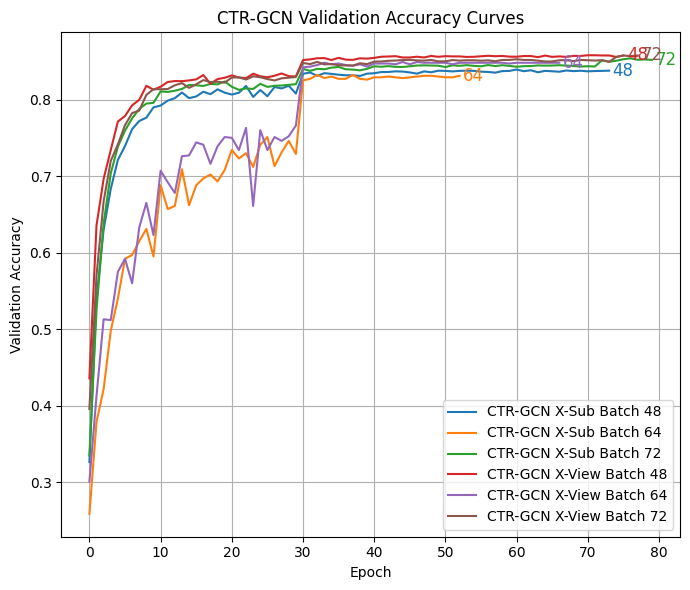

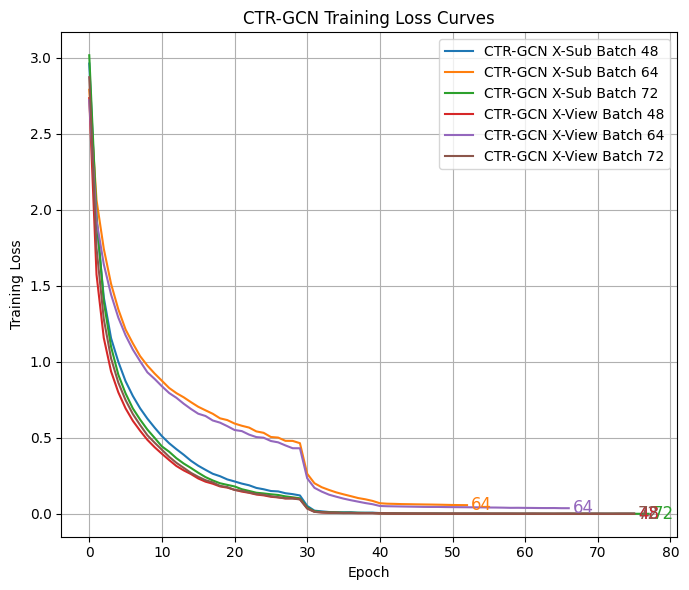

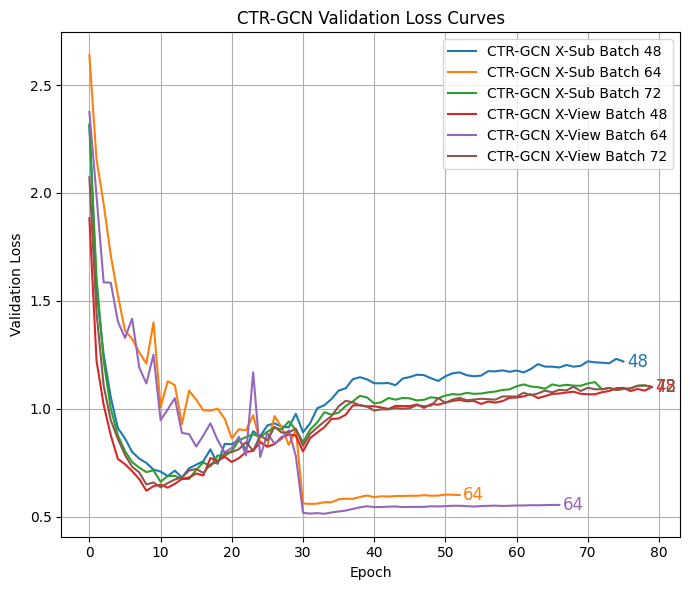

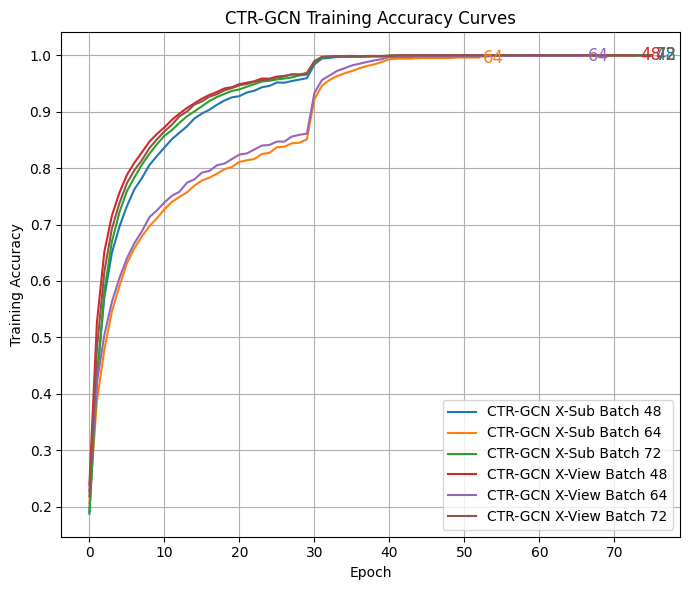

In [ ]:
import matplotlib.pyplot as plt
train_loss_72_xsub = [
    3.0168, 1.9632, 1.3956, 1.0994, 0.9159, 0.7924, 0.6936, 0.6203, 0.5545, 0.4997, 0.4437, 0.4085, 0.3659, 0.3311, 0.3018, 0.2706, 0.2418, 0.2198, 0.2013, 0.1906, 0.1803, 0.1622, 0.1508, 0.1390, 0.1344, 0.1288, 0.1242, 0.1150, 0.1089, 0.1024,
    0.0422, 0.0173, 0.0122, 0.0097, 0.0092, 0.0079, 0.0077, 0.0071, 0.0062, 0.0060, 0.0039, 0.0023, 0.0024, 0.0025, 0.0018, 0.0017, 0.0016, 0.0016, 0.0015, 0.0013, 0.0013, 0.0010, 0.0012, 0.0013, 0.0012, 0.0013, 0.0010, 0.0010, 0.0008, 0.0008,
    0.0008, 0.0009, 0.0010, 0.0009, 0.0006, 0.0008, 0.0008, 0.0007, 0.0009, 0.0008, 0.0006, 0.0006, 0.0008, 0.0007, 0.0007, 0.0005, 0.0004, 0.0005
]
train_acc_72_xsub = [
    0.1873, 0.4205, 0.5830, 0.6696, 0.7214, 0.7592, 0.7835, 0.8061, 0.8254, 0.8422, 0.8573, 0.8675, 0.8802, 0.8917, 0.9004, 0.9096, 0.9190, 0.9259, 0.9315, 0.9368, 0.9394, 0.9444, 0.9486, 0.9534, 0.9548, 0.9572, 0.9587, 0.9607, 0.9643, 0.9656,
    0.9864, 0.9953, 0.9970, 0.9979, 0.9975, 0.9980, 0.9977, 0.9983, 0.9983, 0.9986, 0.9992, 0.9996, 0.9995, 0.9994, 0.9997, 0.9998, 0.9998, 0.9997, 0.9998, 0.9999, 0.9999, 1.0000, 0.9998, 0.9997, 0.9998, 0.9997, 0.9999, 0.9999, 0.9999, 0.9999,
    0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 1.0000, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999
]
val_loss_72_xsub = [
    2.3178, 1.6078, 1.2230, 1.0016, 0.8764, 0.8046, 0.7530, 0.7276, 0.7067, 0.7151, 0.6619, 0.6886, 0.6893, 0.6748, 0.6753, 0.7174, 0.7519, 0.7328, 0.7837, 0.7811, 0.8047, 0.8540, 0.8692, 0.8822, 0.8684, 0.8942, 0.9127, 0.9042, 0.9416, 0.9023,
    0.8458, 0.9032, 0.9369, 0.9841, 0.9733, 0.9821, 1.0135, 1.0344, 1.0603, 1.0526, 1.0248, 1.0304, 1.0501, 1.0425, 1.0504, 1.0484, 1.0389, 1.0420, 1.0535, 1.0489, 1.0614, 1.0681, 1.0656, 1.0739, 1.0695, 1.0707, 1.0763, 1.0800, 1.0875, 1.0900,
    1.1046, 1.1131, 1.1032, 1.1004, 1.0931, 1.1130, 1.1064, 1.1112, 1.1075, 1.1068, 1.1174, 1.1238, 1.0906, 1.0969, 1.0871, 1.0925, 1.0946, 1.1067, 1.1084, 1.1014
]
val_acc_72_xsub = [
    0.3353, 0.5254, 0.6381, 0.7037, 0.7384, 0.7594, 0.7754, 0.7878, 0.7947, 0.7957, 0.8106, 0.8099, 0.8115, 0.8138, 0.8191, 0.8186, 0.8177, 0.8204, 0.8198, 0.8236, 0.8167, 0.8126, 0.8145, 0.8138, 0.8205, 0.8165, 0.8179, 0.8183, 0.8192, 0.8200,
    0.8400, 0.8374, 0.8401, 0.8395, 0.8416, 0.8426, 0.8395, 0.8391, 0.8381, 0.8401, 0.8434, 0.8428, 0.8436, 0.8427, 0.8425, 0.8434, 0.8444, 0.8446, 0.8444, 0.8442, 0.8424, 0.8447, 0.8440, 0.8449, 0.8440, 0.8434, 0.8450, 0.8437, 0.8448, 0.8439,
    0.8428, 0.8436, 0.8437, 0.8445, 0.8443, 0.8444, 0.8448, 0.8443, 0.8438, 0.8431, 0.8435, 0.8431, 0.8513, 0.8493, 0.8507, 0.8526, 0.8538, 0.8519, 0.8523, 0.8518
]

train_loss_72_xview = [
    2.8723, 1.7488, 1.2818, 1.0229, 0.8635, 0.7483, 0.6567, 0.5842, 0.5173, 0.4681, 0.4215, 0.3751, 0.3357, 0.3028, 0.2696, 0.2437, 0.2215, 0.2070, 0.1841, 0.1760, 0.1573, 0.1518, 0.1406, 0.1304, 0.1260, 0.1162, 0.1094, 0.1024, 0.1007, 0.0950,
    0.0352, 0.0128, 0.0096, 0.0077, 0.0060, 0.0050, 0.0050, 0.0049, 0.0049, 0.0052, 0.0032, 0.0022, 0.0018, 0.0016, 0.0015, 0.0015, 0.0015, 0.0014, 0.0012, 0.0011, 0.0012, 0.0013, 0.0010, 0.0009, 0.0007, 0.0007, 0.0007, 0.0007, 0.0008, 0.0008,
    0.0005, 0.0007, 0.0007, 0.0007, 0.0008, 0.0007, 0.0007, 0.0007, 0.0004, 0.0005, 0.0007, 0.0005, 0.0005, 0.0007, 0.0007, 0.0006
]
train_acc_72_xview = [
    0.2180, 0.4794, 0.6171, 0.6928, 0.7376, 0.7731, 0.7963, 0.8142, 0.8354, 0.8507, 0.8650, 0.8769, 0.8917, 0.9001, 0.9126, 0.9182, 0.9266, 0.9310, 0.9377, 0.9419, 0.9467, 0.9492, 0.9527, 0.9558, 0.9572, 0.9605, 0.9624, 0.9661, 0.9653, 0.9680,
    0.9889, 0.9972, 0.9976, 0.9980, 0.9986, 0.9989, 0.9985, 0.9987, 0.9987, 0.9984, 0.9989, 0.9996, 0.9996, 0.9996, 0.9997, 0.9997, 0.9997, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9998, 0.9998, 0.9999, 0.9998, 1.0000, 0.9998, 0.9998, 0.9998,
    0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 1.0000, 0.9999, 0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998
]
val_loss_72_xview = [
    2.0729, 1.4459, 1.1080, 0.9475, 0.8606, 0.7864, 0.7315, 0.7056, 0.6495, 0.6587, 0.6362, 0.6560, 0.6724, 0.6821, 0.7142, 0.7213, 0.7032, 0.7421, 0.7533, 0.7937, 0.7996, 0.8126, 0.8455, 0.8057, 0.8764, 0.8532, 0.9171, 0.8896, 0.8915, 0.9077,
    0.8288, 0.8841, 0.9134, 0.9412, 0.9663, 1.0115, 1.0373, 1.0298, 1.0161, 1.0099, 0.9918, 0.9977, 0.9972, 1.0036, 1.0006, 1.0031, 1.0168, 1.0123, 1.0152, 1.0496, 1.0279, 1.0428, 1.0504, 1.0398, 1.0429, 1.0467, 1.0447, 1.0424, 1.0569, 1.0575,
    1.0567, 1.0745, 1.0630, 1.0711, 1.0845, 1.0761, 1.0883, 1.0853, 1.1025, 1.0825, 1.0974, 1.0905, 1.0906, 1.0969, 1.0871, 1.0925, 1.0946, 1.1067, 1.1084, 1.1014
]
val_acc_72_xview = [
    0.3959, 0.5703, 0.6672, 0.7198, 0.7414, 0.7665, 0.7823, 0.7856, 0.8061, 0.8135, 0.8134, 0.8137, 0.8186, 0.8215, 0.8152, 0.8198, 0.8254, 0.8228, 0.8232, 0.8220, 0.8287, 0.8289, 0.8261, 0.8303, 0.8291, 0.8267, 0.8249, 0.8277, 0.8285, 0.8294,
    0.8477, 0.8463, 0.8491, 0.8459, 0.8463, 0.8448, 0.8445, 0.8444, 0.8473, 0.8462, 0.8495, 0.8497, 0.8506, 0.8509, 0.8515, 0.8518, 0.8511, 0.8508, 0.8517, 0.8498, 0.8499, 0.8515, 0.8508, 0.8513, 0.8513, 0.8507, 0.8512, 0.8500, 0.8517, 0.8517,
    0.8526, 0.8517, 0.8517, 0.8508, 0.8497, 0.8497, 0.8513, 0.8513, 0.8502, 0.8517, 0.8513, 0.8509, 0.8513, 0.8493, 0.8556, 0.8575, 0.8566, 0.8575
]

train_loss_48_xsub = [
    2.9623, 1.9249, 1.4243, 1.1561, 1.0007, 0.8724, 0.7756, 0.6945, 0.6266, 0.5670, 0.5112, 0.4645, 0.4253, 0.3889, 0.3492, 0.3167, 0.2896, 0.2637, 0.2477, 0.2265, 0.2132, 0.1991, 0.1880, 0.1706, 0.1618, 0.1503, 0.1477, 0.1358, 0.1297, 0.1211,
    0.0520, 0.0211, 0.0164, 0.0122, 0.0105, 0.0103, 0.0106, 0.0077, 0.0076, 0.0078, 0.0054, 0.0033, 0.0039, 0.0027, 0.0027, 0.0026, 0.0022, 0.0023, 0.0027, 0.0016, 0.0019, 0.0019, 0.0021, 0.0019, 0.0028, 0.0017, 0.0017, 0.0017, 0.0017, 0.0014,
    0.0015, 0.0017, 0.0012, 0.0013, 0.0010, 0.0014, 0.0016, 0.0013, 0.0013, 0.0016, 0.0015, 0.0015, 0.0013, 0.0015, 0.0016, 0.0015
]
train_acc_48_xsub = [
    0.1897, 0.4296, 0.5719, 0.6497, 0.6959, 0.7326, 0.7625, 0.7823, 0.8055, 0.8213, 0.8365, 0.8513, 0.8627, 0.8738, 0.8880, 0.8967, 0.9035, 0.9122, 0.9198, 0.9254, 0.9275, 0.9341, 0.9371, 0.9433, 0.9457, 0.9518, 0.9513, 0.9544, 0.9568, 0.9594,
    0.9837, 0.9941, 0.9954, 0.9969, 0.9975, 0.9972, 0.9972, 0.9975, 0.9981, 0.9977, 0.9986, 0.9993, 0.9991, 0.9995, 0.9993, 0.9997, 0.9998, 0.9995, 0.9995, 0.9999, 0.9996, 0.9996, 0.9994, 0.9996, 0.9992, 0.9996, 0.9996, 0.9997, 0.9997, 0.9998,
    0.9997, 0.9996, 0.9998, 0.9998, 0.9999, 0.9997, 0.9997, 0.9997, 0.9997, 0.9996, 0.9998, 0.9998, 0.9997, 0.9998, 0.9997, 0.9998
]
val_loss_48_xsub = [
    2.3126, 1.5496, 1.2514, 1.0542, 0.9104, 0.8628, 0.8003, 0.7690, 0.7492, 0.7185, 0.7092, 0.6886, 0.7134, 0.6818, 0.7244, 0.7409, 0.7574, 0.8123, 0.7446, 0.8375, 0.8358, 0.8584, 0.8109, 0.8961, 0.8737, 0.9231, 0.9328, 0.9175, 0.9146, 0.9767,
    0.8913, 0.9329, 1.0027, 1.0165, 1.0453, 1.0843, 1.0952, 1.1373, 1.1465, 1.1367, 1.1183, 1.1183, 1.1195, 1.1094, 1.1403, 1.1473, 1.1580, 1.1560, 1.1413, 1.1292, 1.1509, 1.1644, 1.1689, 1.1556, 1.1508, 1.1538, 1.1744, 1.1735, 1.1783, 1.1716,
    1.1775, 1.1687, 1.1844, 1.2071, 1.1956, 1.1953, 1.1915, 1.2032, 1.1952, 1.1993, 1.2200, 1.2154, 1.2137, 1.2109, 1.2316, 1.2190
]
val_acc_48_xsub = [
    0.3266, 0.5403, 0.6302, 0.6833, 0.7212, 0.7392, 0.7613, 0.7720, 0.7763, 0.7898, 0.7921, 0.7986, 0.8018, 0.8091, 0.8018, 0.8040, 0.8102, 0.8070, 0.8133, 0.8090, 0.8065, 0.8088, 0.8178, 0.8034, 0.8124, 0.8043, 0.8163, 0.8145, 0.8179, 0.8078,
    0.8336, 0.8353, 0.8309, 0.8344, 0.8335, 0.8324, 0.8317, 0.8316, 0.8308, 0.8338, 0.8343, 0.8359, 0.8360, 0.8368, 0.8365, 0.8354, 0.8338, 0.8367, 0.8356, 0.8376, 0.8374, 0.8367, 0.8374, 0.8377, 0.8374, 0.8364, 0.8360, 0.8351, 0.8371, 0.8374,
    0.8392, 0.8370, 0.8382, 0.8356, 0.8374, 0.8369, 0.8363, 0.8379, 0.8371, 0.8376, 0.8368, 0.8372, 0.8374, 0.8377
]

train_loss_48_xview = [
    2.7348, 1.5746, 1.1575, 0.9375, 0.7995, 0.6938, 0.6120, 0.5469, 0.4871, 0.4383, 0.3952, 0.3539, 0.3147, 0.2860, 0.2618, 0.2328, 0.2118, 0.1983, 0.1805, 0.1726, 0.1585, 0.1465, 0.1385, 0.1272, 0.1217, 0.1123, 0.1081, 0.1013, 0.1026, 0.0965,
    0.0357, 0.0136, 0.0092, 0.0071, 0.0076, 0.0057, 0.0062, 0.0048, 0.0050, 0.0047, 0.0027, 0.0025, 0.0017, 0.0017, 0.0017, 0.0015, 0.0014, 0.0015, 0.0009, 0.0013, 0.0014, 0.0011, 0.0010, 0.0011, 0.0011, 0.0010, 0.0012, 0.0011, 0.0010, 0.0008,
    0.0008, 0.0011, 0.0009, 0.0006, 0.0007, 0.0008, 0.0009, 0.0005, 0.0007, 0.0007, 0.0007, 0.0004, 0.0005, 0.0007, 0.0007, 0.0006
]
train_acc_48_xview = [
    0.2391, 0.5260, 0.6523, 0.7157, 0.7563, 0.7879, 0.8094, 0.8280, 0.8469, 0.8605, 0.8721, 0.8856, 0.8965, 0.9065, 0.9148, 0.9231, 0.9297, 0.9349, 0.9412, 0.9434, 0.9489, 0.9513, 0.9540, 0.9588, 0.9585, 0.9622, 0.9635, 0.9661, 0.9660, 0.9682,
    0.9894, 0.9969, 0.9977, 0.9984, 0.9981, 0.9985, 0.9985, 0.9987, 0.9987, 0.9987, 0.9993, 0.9994, 0.9997, 0.9997, 0.9997, 0.9998, 0.9997, 0.9996, 0.9999, 0.9998, 0.9997, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9998, 0.9998, 0.9999,
    0.9999, 0.9998, 0.9998, 0.9999, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998
]
val_loss_48_xview = [
    1.8833, 1.2233, 1.0188, 0.8778, 0.7676, 0.7435, 0.7112, 0.6745, 0.6206, 0.6414, 0.6490, 0.6346, 0.6526, 0.6751, 0.6822, 0.7005, 0.6910, 0.7720, 0.7587, 0.7777, 0.7536, 0.7714, 0.7999, 0.8050, 0.8464, 0.8243, 0.8366, 0.8688, 0.8813, 0.8755,
    0.8024, 0.8643, 0.8901, 0.9148, 0.9531, 0.9550, 0.9728, 1.0157, 1.0162, 1.0114, 1.0121, 1.0062, 0.9994, 1.0138, 1.0127, 1.0126, 1.0202, 1.0043, 1.0217, 1.0194, 1.0285, 1.0368, 1.0411, 1.0346, 1.0365, 1.0228, 1.0337, 1.0290, 1.0356, 1.0509,
    1.0522, 1.0578, 1.0678, 1.0498, 1.0586, 1.0691, 1.0709, 1.0755, 1.0793, 1.0696, 1.0675, 1.0672, 1.0768, 1.0825, 1.0959, 1.0970, 1.0821, 1.0918, 1.0842, 1.1012
]
val_acc_48_xview = [
    0.4359, 0.6358, 0.6965, 0.7341, 0.7712, 0.7785, 0.7924, 0.7996, 0.8179, 0.8128, 0.8167, 0.8229, 0.8241, 0.8240, 0.8250, 0.8263, 0.8320, 0.8205, 0.8267, 0.8284, 0.8315, 0.8288, 0.8279, 0.8337, 0.8304, 0.8290, 0.8311, 0.8340, 0.8305, 0.8302,
    0.8515, 0.8524, 0.8539, 0.8541, 0.8516, 0.8544, 0.8521, 0.8518, 0.8538, 0.8534, 0.8544, 0.8559, 0.8562, 0.8566, 0.8549, 0.8549, 0.8559, 0.8549, 0.8569, 0.8558, 0.8566, 0.8563, 0.8563, 0.8556, 0.8558, 0.8565, 0.8571, 0.8566, 0.8569, 0.8560,
    0.8559, 0.8568, 0.8568, 0.8553, 0.8574, 0.8557, 0.8563, 0.8557, 0.8570, 0.8569, 0.8578, 0.8578, 0.8575, 0.8575, 0.8556, 0.8575
]

train_loss_64_xsub_ctr = [
    3.4166, 2.4135, 1.9492, 1.6274, 1.3578, 1.1867, 1.0549, 0.9413, 0.8640, 0.8023,
    0.7378, 0.6949, 0.6513, 0.6045, 0.5774, 0.5385, 0.5085, 0.4817, 0.4581, 0.4282,
    0.4142, 0.3837, 0.3743, 0.3567, 0.3389, 0.3218, 0.3039, 0.2953, 0.2831, 0.3019,
    0.1960, 0.1368, 0.1160, 0.0997, 0.0914, 0.0841, 0.0777, 0.0723, 0.0666, 0.0634,
    0.0519, 0.0466, 0.0449, 0.0445, 0.0426, 0.0436, 0.0406, 0.0395, 0.0415, 0.0400,
    0.0397, 0.0379, 0.0362, 0.0390, 0.0362, 0.0375, 0.0365, 0.0357, 0.0370, 0.0339,
    0.0358, 0.0334, 0.0330, 0.0340, 0.0334
]

train_acc_64_xsub_ctr = [
    0.1004, 0.3008, 0.4250, 0.5157, 0.5929, 0.6465, 0.6844, 0.7184, 0.7374, 0.7564,
    0.7757, 0.7864, 0.7966, 0.8121, 0.8192, 0.8320, 0.8396, 0.8437, 0.8565, 0.8638,
    0.8659, 0.8770, 0.8789, 0.8854, 0.8907, 0.8950, 0.9001, 0.9039, 0.9081, 0.9009,
    0.9364, 0.9558, 0.9636, 0.9693, 0.9716, 0.9729, 0.9756, 0.9768, 0.9786, 0.9807,
    0.9841, 0.9859, 0.9871, 0.9868, 0.9881, 0.9872, 0.9883, 0.9888, 0.9874, 0.9882,
    0.9885, 0.9888, 0.9895, 0.9888, 0.9896, 0.9890, 0.9896, 0.9902, 0.9890, 0.9899,
    0.9901, 0.9909, 0.9912, 0.9903, 0.9903
]

val_loss_64_xsub_ctr = [
    2.7744, 2.1189, 1.7627, 1.4593, 1.2605, 1.1287, 1.0126, 0.9591, 0.9462, 0.8590,
    0.8595, 0.8298, 0.7914, 0.8229, 0.8554, 0.7960, 1.1352, 0.8095, 0.7802, 1.6741,
    0.8154, 0.8147, 1.0669, 0.8289, 0.8602, 0.9929, 1.3191, 2.2922, 8.7799, 0.8693,
    0.8390, 0.8855, 0.9304, 0.9776, 1.0124, 1.0375, 1.0640, 1.0784, 1.1029, 1.1214,
    1.1030, 1.1123, 1.1184, 1.1251, 1.1442, 1.1447, 1.1331, 1.1422, 1.1453, 1.1530,
    1.1563, 1.1652, 1.1591, 1.1741, 1.1836, 1.1802, 1.1757, 1.1849, 1.1908, 1.1985,
    1.2259, 1.2174, 1.2203, 1.2129, 1.2176
]

val_acc_64_xsub_ctr = [
    0.2190, 0.3838, 0.4861, 0.5684, 0.6241, 0.6684, 0.7058, 0.7177, 0.7296, 0.7516,
    0.7511, 0.7630, 0.7739, 0.7685, 0.7754, 0.7793, 0.7830, 0.7784, 0.7845, 0.7884,
    0.7882, 0.7890, 0.7910, 0.7896, 0.7895, 0.7914, 0.7918, 0.7902, 0.7877, 0.7902,
    0.8126, 0.8134, 0.8112, 0.8130, 0.8125, 0.8133, 0.8121, 0.8117, 0.8107, 0.8100,
    0.8129, 0.8137, 0.8133, 0.8136, 0.8151, 0.8132, 0.8151, 0.8137, 0.8142, 0.8146,
    0.8137, 0.8131, 0.8152, 0.8142, 0.8132, 0.8144, 0.8141, 0.8145, 0.8135, 0.8132,
    0.8130, 0.8134, 0.8137, 0.8143, 0.8136
]

train_loss_64_xview_ctr = [
    3.0094, 2.0211, 1.5466, 1.2190, 1.0108, 0.8759, 0.7821, 0.7065, 0.6489, 0.5903,
    0.5495, 0.4973, 0.4714, 0.4355, 0.4094, 0.3772, 0.3607, 0.3293, 0.3149, 0.2907,
    0.2754, 0.2627, 0.2509, 0.2398, 0.2207, 0.2088, 0.2066, 0.1917, 0.1788, 0.1764,
    0.0881, 0.0517, 0.0378, 0.0331, 0.0281, 0.0259, 0.0238, 0.0211, 0.0195, 0.0189,
    0.0130, 0.0100, 0.0094, 0.0098, 0.0090, 0.0086, 0.0091, 0.0082, 0.0075, 0.0075,
    0.0078, 0.0069, 0.0074, 0.0067, 0.0065, 0.0073, 0.0065
]

train_acc_64_xview_ctr = [
    0.1758, 0.4030, 0.5371, 0.6333, 0.6979, 0.7347, 0.7601, 0.7836, 0.7994, 0.8154,
    0.8280, 0.8427, 0.8515, 0.8590, 0.8691, 0.8782, 0.8837, 0.8933, 0.8976, 0.9057,
    0.9092, 0.9142, 0.9180, 0.9226, 0.9292, 0.9308, 0.9321, 0.9364, 0.9402, 0.9429,
    0.9726, 0.9837, 0.9886, 0.9899, 0.9913, 0.9921, 0.9926, 0.9936, 0.9944, 0.9943,
    0.9968, 0.9978, 0.9977, 0.9973, 0.9978, 0.9981, 0.9979, 0.9980, 0.9984, 0.9984,
    0.9978, 0.9983, 0.9982, 0.9983, 0.9985, 0.9982, 0.9985
]

val_loss_64_xview_ctr = [
    2.2616, 1.6914, 1.3067, 1.0762, 0.9583, 0.8738, 0.8070, 0.7641, 0.7296, 0.7056,
    0.7036, 0.6917, 0.6712, 0.6742, 0.6926, 0.7157, 0.6987, 0.6967, 0.7017, 0.7394,
    0.7359, 0.7693, 0.7914, 0.7729, 0.8060, 0.8144, 0.8562, 0.8272, 0.8867, 0.8662,
    0.8372, 0.8947, 0.9269, 0.9866, 1.0054, 1.0663, 1.0453, 1.1032, 1.1049, 1.1164,
    1.0915, 1.0982, 1.1105, 1.1087, 1.1183, 1.1277, 1.1266, 1.1384, 1.1477, 1.1450,
    1.1503, 1.1492, 1.1584, 1.1677, 1.1619, 1.1702, 1.1859
]

val_acc_64_xview_ctr = [
    0.3501, 0.5004, 0.6116, 0.6832, 0.7109, 0.7387, 0.7636, 0.7773, 0.7840, 0.7924,
    0.7953, 0.7994, 0.8095, 0.8076, 0.8071, 0.8097, 0.8132, 0.8161, 0.8184, 0.8086,
    0.8152, 0.8159, 0.8133, 0.8195, 0.8156, 0.8191, 0.8177, 0.8183, 0.8121, 0.8177,
    0.8384, 0.8380, 0.8385, 0.8393, 0.8382, 0.8360, 0.8364, 0.8350, 0.8338, 0.8334,
    0.8395, 0.8387, 0.8384, 0.8415, 0.8387, 0.8392, 0.8399, 0.8399, 0.8408, 0.8399,
    0.8404, 0.8402, 0.8406, 0.8382, 0.8399, 0.8401, 0.8376
]


# PLOT ALL IN ONE CELL

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def annotate_curve(y, label, x_shift=0.5, y_shift=0, color=None):
    """Annotate the last point of a curve with the given label."""
    plt.text(len(y)-1 + x_shift, y[-1] + y_shift, label, fontsize=12, color=color, va='center')

# --- Validation Accuracy ---
plt.figure(figsize=(7, 6))
plt.plot(val_acc_48_xsub, label='CTR-GCN X-Sub Batch 48')
plt.plot(val_acc_64_xsub, label='CTR-GCN X-Sub Batch 64')
plt.plot(val_acc_72_xsub, label='CTR-GCN X-Sub Batch 72')
plt.plot(val_acc_48_xview, label='CTR-GCN X-View Batch 48')
plt.plot(val_acc_64_xview, label='CTR-GCN X-View Batch 64')
plt.plot(val_acc_72_xview, label='CTR-GCN X-View Batch 72')

# Add annotation to end of each curve
annotate_curve(val_acc_48_xsub, '48', color='C0')
annotate_curve(val_acc_64_xsub, '64', color='C1')
annotate_curve(val_acc_72_xsub, '72', color='C2')
annotate_curve(val_acc_48_xview, '48', color='C3')
annotate_curve(val_acc_64_xview, '64', color='C4')
annotate_curve(val_acc_72_xview, '72', color='C5')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('CTR-GCN Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Training Loss ---
plt.figure(figsize=(7, 6))
plt.plot(train_loss_48_xsub, label='CTR-GCN X-Sub Batch 48')
plt.plot(train_loss_64_xsub, label='CTR-GCN X-Sub Batch 64')
plt.plot(train_loss_72_xsub, label='CTR-GCN X-Sub Batch 72')
plt.plot(train_loss_48_xview, label='CTR-GCN X-View Batch 48')
plt.plot(train_loss_64_xview, label='CTR-GCN X-View Batch 64')
plt.plot(train_loss_72_xview, label='CTR-GCN X-View Batch 72')

annotate_curve(train_loss_48_xsub, '48', color='C0')
annotate_curve(train_loss_64_xsub, '64', color='C1')
annotate_curve(train_loss_72_xsub, '72', color='C2')
annotate_curve(train_loss_48_xview, '48', color='C3')
annotate_curve(train_loss_64_xview, '64', color='C4')
annotate_curve(train_loss_72_xview, '72', color='C5')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('CTR-GCN Training Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Validation Loss ---
plt.figure(figsize=(7, 6))
plt.plot(val_loss_48_xsub, label='CTR-GCN X-Sub Batch 48')
plt.plot(val_loss_64_xsub, label='CTR-GCN X-Sub Batch 64')
plt.plot(val_loss_72_xsub, label='CTR-GCN X-Sub Batch 72')
plt.plot(val_loss_48_xview, label='CTR-GCN X-View Batch 48')
plt.plot(val_loss_64_xview, label='CTR-GCN X-View Batch 64')
plt.plot(val_loss_72_xview, label='CTR-GCN X-View Batch 72')

annotate_curve(val_loss_48_xsub, '48', color='C0')
annotate_curve(val_loss_64_xsub, '64', color='C1')
annotate_curve(val_loss_72_xsub, '72', color='C2')
annotate_curve(val_loss_48_xview, '48', color='C3')
annotate_curve(val_loss_64_xview, '64', color='C4')
annotate_curve(val_loss_72_xview, '72', color='C5')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('CTR-GCN Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Training Accuracy ---
plt.figure(figsize=(7, 6))
plt.plot(train_acc_48_xsub, label='CTR-GCN X-Sub Batch 48')
plt.plot(train_acc_64_xsub, label='CTR-GCN X-Sub Batch 64')
plt.plot(train_acc_72_xsub, label='CTR-GCN X-Sub Batch 72')
plt.plot(train_acc_48_xview, label='CTR-GCN X-View Batch 48')
plt.plot(train_acc_64_xview, label='CTR-GCN X-View Batch 64')
plt.plot(train_acc_72_xview, label='CTR-GCN X-View Batch 72')

annotate_curve(train_acc_48_xsub, '48', color='C0')
annotate_curve(train_acc_64_xsub, '64', color='C1')
annotate_curve(train_acc_72_xsub, '72', color='C2')
annotate_curve(train_acc_48_xview, '48', color='C3')
annotate_curve(train_acc_64_xview, '64', color='C4')
annotate_curve(train_acc_72_xview, '72', color='C5')

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('CTR-GCN Training Accuracy Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
